In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [68]:
def to_seconds(str):
        splitted=str.split(':')
        return (int(splitted[0])*3600+int(splitted[1])*60+int(splitted[2]))

def string_split(str):
        import datetime
        a=str.split('/')
        day,month,year=int(a[0]),int(a[1]),int(a[2])
        return datetime.datetime(day=day,month=month,year=2000+year)

def month(str):
        month=str.split('/')[1]
        months={1:'January',2:'Feburary',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
        return months[int(month)]

def indexDates(date):
        return (date.split('/'))[0]

#const R = 6371e3; // metres
# const φ1 = lat1 * Math.PI/180; // φ, λ in radians
# const φ2 = lat2 * Math.PI/180;
# const Δφ = (lat2-lat1) * Math.PI/180;
# const Δλ = (lon2-lon1) * Math.PI/180;

# const a = Math.sin(Δφ/2) * Math.sin(Δφ/2) +
#           Math.cos(φ1) * Math.cos(φ2) *
#           Math.sin(Δλ/2) * Math.sin(Δλ/2);
# const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));

# const d = R * c;
def calDistanceLatLong(lat1,lat2,delLong):
    #delLong and delLat are simply the differece between the longitudes and latitudes respectively.
        delLat=(lat2-lat1)*(np.pi/180)
        a=(np.sin(delLat/2))**2+np.cos(lat1)*np.cos(lat2)*(np.sin((delLong/2)*(np.pi/180)))**2
        c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
        return 6371000*c
        # except:
        #     return 0;

'''Function to calculate the mean squared error. 'true' is the actual value and 'pred' is the predicted value.'''
def mean_squared_error(true,pred):
    error=0
    for i in range(0,true.size):
        error+=(true[i]-pred[i])**2
    return error

'''
Function to find the best fit function for given values of 'x' produce the nearest values to 'y' and of maximum degree 'largestDegree' 
'''
def findBestFitFunction(x,y,largestDegree):
    BestFitFunction={}# Dict(key=deg, value=[functionvalues])
    minimum=0
    deg=2
    for i in range(2,largestDegree):
        z=np.polyfit(x,y,deg=i)
        F=np.poly1d(z)
        Y=np.array([])
        for j in x:
            Y=np.append(Y,F(j))
        error=mean_squared_error(y,Y)
        #print(error,end="*")
        match i:
            case 2:
                minimum=error
                BestFitFunction[deg]=[z,Y]
            case _:
                if error<minimum:
                    #print('Reached')
                    minimum=error
                    deg=i
                    BestFitFunction[deg]=[z,Y]
    return BestFitFunction[deg]
    #print(deg,error)
   

In [69]:
class Data:
    #This is the main dataFrame or the parent Dataframe
    df=pd.DataFrame({})
    #This is the child dataFrame derived from the first one.
    df2=pd.DataFrame({})
    MileageArray=np.array([])
    #For storing the average speeds of the given data
    Speeds=np.array([])
    #For storing all the unique dates in the given data
    dates=np.array([])
    
    #odo={}
     #In the constructor we are doing all the precalculations like:
    '''
        1. Sorting the data according to date and time
        2. Reseting the indices after the sorting
        3. Defining the Energy Column
        4. Defining the Energy Consumed Column
        5. Identifying all the unique dates and storing it in 'dates'.
    '''
    def __init__(self,dataframe):
        self.df.drop(self.df.index,inplace=True)
        self.df2.drop(self.df2.index,inplace=True)
        self.MileageArray=np.array([])
        self.Speeds=np.array([])
        self.dates=np.array([])
        
        self.df=dataframe

        '''Here we are sorting the data on the basis of both date and time'''
        self.df['DateModified']=self.df['date'].map(string_split)
        self.df['Time_seconds']=self.df['time'].map(to_seconds)
        self.df.sort_values(['DateModified','Time_seconds'],inplace=True)
        
        #self.df.drop(df['lat'])
        self.df['latPrevious']=self.df['lat'].shift(1)
        self.df['long2-long1']=self.df['long'].diff(1)
        #Here we are applying the function calDistanceLatLong defined above to calculate the distance between two points.
        self.df['Distance']=self.df.apply(lambda r:calDistanceLatLong(r['lat'],r['latPrevious'],r['long2-long1']),axis=1)
        
        self.df['Energy_Wh']=(self.df['cummulativeDischarge']*self.df['batVolt'])/1000
        self.df['EnergyConsumed']=(self.df['Energy_Wh']).diff(1).fillna(np.nan)
        
        
        self.df['Month']=self.df['date'].map(month) 
        #Here we are just filtering the data.
        self.df.drop(self.df.loc[(self.df['EnergyConsumed']<=float(0))|(self.df['lat']==0)|(self.df['long']==0)|(self.df['Distance']>170)|(self.df['batCurrent']<=0.0)].index,inplace=True)
        
        #self.filterData()
        self.dates=self.df['date'].unique()
        self.df.reset_index(inplace=True,drop=True)
        self.CalTimeDifference()
        self.CalAverageSpeed()
        self.CalMileage()
        #self.trimArray()

        self.df2=self.df.loc[((self.df['Distance']>float(0))&(self.df['Speed']>float(7))&(self.df['Mileage']!=-1))]
        self.df2=self.df2[['date','time','Mileage','Speed','batCurrent']]
        #self.df2.drop((self.df2['Speed']=='inf').index,inplace=True)
        self.df2.reset_index(inplace=True,drop=True)
        
        self.MileageArray=self.df.loc[(self.df['Distance']>float(0))&(self.df['Speed']>float(7))&(self.df['Mileage']!=-1),'Mileage'].to_numpy(copy=False,dtype=np.float64)
        #Here we are ingnoring all the rows with very low speeds or mileage as notdefined similarly for the mileage array
        self.Speeds=self.df.loc[(self.df['Distance']>float(0))&(self.df['Speed']>float(7))&(self.df['Mileage']!=-1),'Speed'].to_numpy(copy=False,dtype=np.float64)
   
    def CalTimeDifference(self):
        for i in self.dates:
            self.df.loc[self.df['date']==i,'TimeDifference']=(self.df.loc[self.df['date']==i,'Time_seconds']-(self.df.loc[self.df['date']==i,'Time_seconds'].shift(1).fillna(0)))
    
    #In this function we are filtering the data on the basis of the zero current values.
    def filterData(self):
        #self.df.drop(self.df.loc[(self.df['batCurrent']==0)&(self.df['speed']==0)].index,inplace=True)
        self.df.drop(self.df.loc[(self.df['batCurrent']==0)].index,inplace=True)
    
    #This function is for making the sizes of MileageArray and Speeds equal.
    def trimArrays(self):
        sizeM=int(self.MileageArray.size)
        sizeS=int(self.Speeds.size)
        Minimum=(sizeM) if sizeM<=sizeS else sizeS
        print(Minimum)
        if(Minimum<sizeM):
            self.MileageArray=self.MileageArray[:-(sizeM-Minimum)]
        elif (Minimum<sizeS):
            self.Speeds=self.Speeds[:-(sizeS-Minimum)]
            
    def CalMileage(self):
        self.df['Mileage']=-1
        self.df.loc[self.df['Distance']>float(0),'Mileage']=self.df.loc[self.df['Distance']>float(0),'EnergyConsumed']/(self.df.loc[self.df['Distance']>float(0),'Distance']/1000)
        self.df.loc[(self.df['Mileage']>50)|(self.df['Mileage']<float(2)),'Mileage']=-1


    def CalAverageSpeed(self):
        self.df['Speed']=(self.df['Distance']/1000)/(self.df['TimeDifference']/3600)
        
    # def CalAverageMileagePerSpeed(self):
        


In [70]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
# import tensorflow as tf
# import keras
#Here we'll given df2 in its constructor as dataframe.
class LSTM:
    df=pd.DataFrame({})
    windowed_df=pd.DataFrame({})
    sizeOfWindow=3
    #This is our lstm model
    model = Sequential()
    
    '''
        Meaning of the parameters
        1. dataframe: Contains the df2 of the data. (DataFrame)
        2. fileName: Contains the file name where to save the model or from where to load the model from. (String)
        3. percentage_test: It basically represents the fraction of the data to be used to test the mode.
        4. size: Represents the size of the window for our lstm model.
        5. plot: It is a flag used for plotting the actual and predicted value.
        6. train: It is also a flag if TRUE will train the model and save it and if FALSE will load the model and use it for other calculations.
    '''
        
    def __init__(self,dataframe,fileName,train,size,percentage_train=0.8,plot=False,variate='Single'):
        '''We are making sure that at first these dataframes are empty because once generated the data in the dataframes remains for the same object of this
        class.'''
        self.df.drop(self.df.index,inplace=True)
        self.windowed_df.drop(self.windowed_df.index,inplace=True)
        self.sizeOfWindow=size
        self.model=Sequential()
        
        # if(dataframe.shape[0]%self.sizeOfWindow==0):
        #     self.df=dataframe
        # else:
        self.df=dataframe[:((int(dataframe.shape[0]/self.sizeOfWindow))*self.sizeOfWindow)]
        self.windowed_df=LSTM.toWindowedDf(self.df,self.sizeOfWindow,variate)
        if(train):
            '''
            The reason of this try and catch block is to check where a model of this name exist or not.
            If such a model exist then we'll train the model if train is True from the point we left it in the previous training.
            '''
            try:
                self.model=load_model(fileName)
            except:
                self.train(percentage_train=percentage_train,size=self.sizeOfWindow,plot=plot,train=train,variate=variate,partiallyTrained=False)
            finally:
                self.model.save(fileName)
        else:
            #Here if the train flag is false then we'll load the model from the filename given by the user.
           self.model=load_model(fileName)
           self.train(percentage_train=percentage_train,size=self.sizeOfWindow,plot=plot,train=train,variate=variate,partiallyTrained=True)
    
    '''
    This function is basically converting the given dataFrame with to another dataFrame with a windowSize=size 
    '''
    def toWindowedDf(df,size,variate):
        windowed_df=pd.DataFrame({})
        windowed_df['Mileage']=df.loc[size:,'Mileage']
        for i in range(0,size):
            windowed_df[i]=(df['Speed'].shift(i+1))[size:]
        if(variate=='Multi'):
            for i in range(0,size):
                windowed_df[i+size]=(df['batCurrent'].shift(i+1))[size:]
        return windowed_df
        
    '''
    Other parameters are obvious but training represents a flag if true then it will return testing and training data seperately otherwise
    it'll only return testing data.
    '''    
    
    #And also this is a class function i.e a static function common for all the objects. 
    def splitData(percentage_train,windowed_df,size,variate,training=False):
        windowed_df_np=np.array([])
        windowed_df_np=windowed_df.to_numpy(copy=True,dtype=np.float64)
        #print('Shape of the windowed dataframe ',windowed_df_np.shape)
        middle_matrix=windowed_df_np[:,1:]
        X=middle_matrix.reshape(windowed_df_np.shape[0],size,1 if variate=='Single' else 2)
        #print('After converting to x and y the shape of the input is ',X.shape)
        Y=windowed_df_np[:,0]
        if(training):
            q_percentage=int(len(windowed_df_np[:,0])*percentage_train)
            x_train,y_train=X[:q_percentage],Y[:q_percentage]
            x_val,y_val=X[q_percentage:],Y[q_percentage:]
            return x_train,y_train,x_val,y_val,windowed_df_np
        else:
            return X,Y
    
    #This function is basically for training our model.
    def train(self,percentage_train,size,plot,variate,train,partiallyTrained):
            x_train,y_train,x_val,y_val,windowed_df_np=LSTM.splitData(percentage_train,self.windowed_df,size=size,training=True,variate=variate)
            if(train):
                if(not partiallyTrained):
                    self.model = Sequential([layers.Input((size, (1 if variate=='Single' else 2))),
                                    layers.LSTM(64),
                                    layers.Dense(32, activation='relu'),
                                    layers.Dense(32, activation='relu'),
                                    layers.Dense(1)])
                    self.model.compile(loss='mse', 
                                optimizer=Adam(learning_rate=0.001),
                                metrics=['mean_absolute_error'])
                self.model.fit(x_train,y_train, validation_data=(x_val,y_val), epochs=100)
            if(plot):
                predictions=self.model.predict(x_train)
                #print('Original predictions size and shape ',predictions.size,' ',predictions.shape)
                predictions=predictions.flatten()
                q_percentage=int(len(windowed_df_np[:,0])*percentage_train)
                function=findBestFitFunction(windowed_df_np[:q_percentage,1],predictions,3)
                plt.scatter(windowed_df_np[:q_percentage,1],y_train)
                plt.scatter(windowed_df_np[:q_percentage,1],predictions)
                plt.scatter(windowed_df_np[:q_percentage,1],function[1],color='black')
                plt.xlabel('Speed in Km/hr')
                plt.ylabel('Mileage in Wh/Km')
                plt.title('Plotting the actual and predicted values')
                plt.suptitle('Using multiVariate LSTM' if  variate=='Multi' else 'Using singleVariate LSTM')
                plt.legend(['Actual','Predicted','Trend of Predicted values'])
                #print("prediction size = ",predictions.size," ",predictions.shape,'The number of inputs ',windowed_df_np[:,1].size)
        

In [71]:
columns_to_pick=['date','time','speed','batVolt','batCurrent','cummulativeDischarge','lat','long','longDirection','latDirection']
try:
    df=pd.read_csv('1monthdata.csv',usecols=columns_to_pick)
except:
    print('Error in reading the csv file.\n Either it doesn\'t exist or the columns doesn\'t exist.')
#loading the one month data
OneMonth=Data(df)

In [72]:
for i in range(0,11):
    print(type(OneMonth.df.iloc[0,i]),end=" ")

<class 'str'> <class 'str'> <class 'numpy.float64'> <class 'str'> <class 'numpy.float64'> <class 'str'> <class 'numpy.int64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'pandas._libs.tslibs.timestamps.Timestamp'> 

In [73]:
print(OneMonth.Speeds.size,OneMonth.MileageArray.size)
OneMonth.MileageArray[:11]

560 560


array([10.45645519, 14.49825369,  6.9540793 , 35.48089359,  6.55704749,
        8.05393976,  7.07944477, 20.88815079,  6.02335173, 19.59465459,
       27.0470468 ])

<h3>Function for calculating the mileage for a given dataframe <b>df</b> and modified dataframe <b>df2</b></h3>

<h2>Correlation between mileage and speed
</h2>

Text(0.5, 1.0, 'Plotting the mileage and speed data for the \nfirst five days of the One Month data.')

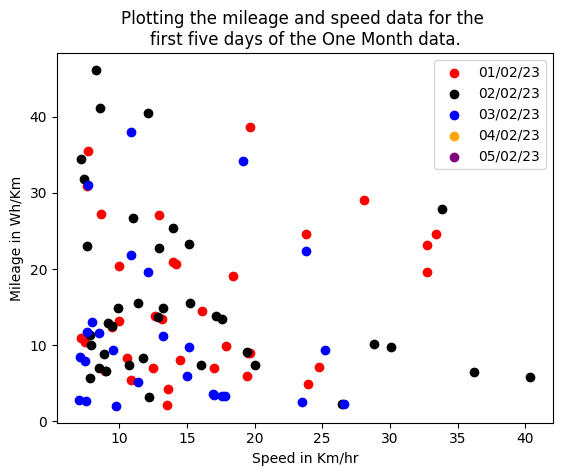

In [74]:
#pd.options.display.max_rows=100
# OneMonth.df.head(10)
#OneMonth.df.to_csv('Example.csv')

colour=['red','black','blue','orange','purple']
for i in range(0,5):
    #plt.scatter(OneMonth.df.loc[(OneMonth.df['Distance']>float(0))&(OneMonth.df['date']==OneMonth.dates[i])&(OneMonth.df['Speed']>float(7)),'Speed'],OneMonth.df.loc[(OneMonth.df['Distance']>float(0))&(OneMonth.df['date']==OneMonth.dates[i])&(OneMonth.df['Speed']>float(7)),'Mileage'],color=colour[i])
    plt.scatter(OneMonth.df2.loc[OneMonth.df2['date']==OneMonth.dates[i],'Speed'],OneMonth.df2.loc[OneMonth.df2['date']==OneMonth.dates[i],'Mileage'],color=colour[i])
plt.legend(OneMonth.dates[:5])
plt.ylabel('Mileage in Wh/Km')
plt.xlabel('Speed in Km/hr')
plt.title('Plotting the mileage and speed data for the \nfirst five days of the One Month data.')

<h3>Function for find the mean squared error and printing the function</h3>

In [75]:
#This function is basically generating a latex string which repersents the function.
def toLatexString(coff):
    output="$ "
    for i in range(0,coff.size-1):
        output+=(str(coff[i]) if coff[i]>=0 else '('+str(coff[i])+')') +(('\\times x^'+'{'+str(coff.size-i-1) +'} + ') if (coff.size-i-1)!=1 else ('\\times x'+' + '))
    output+=str(coff[-1])+" $"
    return output

#Here we are representing the function in a beautiful way by writing it in latex.
def print_function(coff):
    from IPython.display import Latex
    return Latex(toLatexString(coff))

<h3>Finding the corelation between speed and mileage</h3>
<p>In this code below we are basically finding the <strong>best</strong> function of degree n for this we are checking the error value for each value of degree of the polynomial.</p>

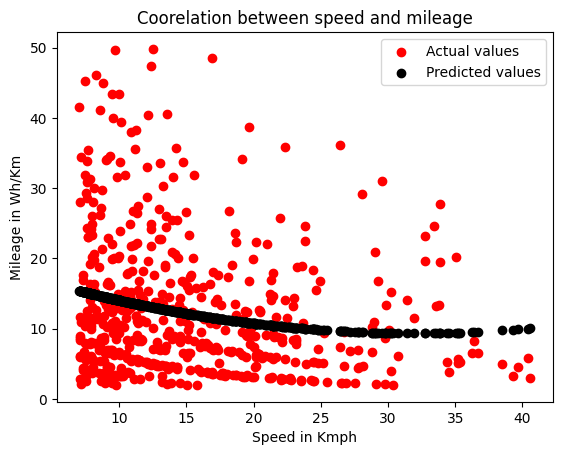

In [76]:
function=findBestFitFunction(OneMonth.Speeds,OneMonth.MileageArray,3)
plt.scatter(OneMonth.Speeds,OneMonth.MileageArray,color='red')
#plt.scatter(OneMonth.df['AverageSpeed_Kmph'],OneMonth.df['mileage'])
plt.scatter(OneMonth.Speeds,function[1],color='black')
plt.xlabel("Speed in Kmph")
plt.ylabel("Mileage in Wh/Km")
plt.legend(['Actual values','Predicted values'])
plt.title('Coorelation between speed and mileage')
plt.show()
#print(BestFitFunction)

In [77]:
print_function(function[0])

<IPython.core.display.Latex object>

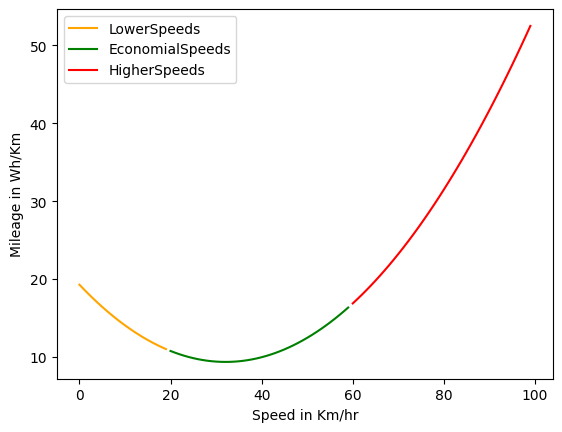

In [78]:
F=np.poly1d(function[0])
y=np.array([])
x=np.arange(100)
for i in x:
    y=np.append(y,F(i))
# plt.plot(x,y)
plt.plot(x[x<20],y[:20],color='orange')
plt.plot(x[(x>=20)&(x<60)],y[20:60],color='green')
plt.plot(x[x>=60],y[60:],color='red')
plt.xlabel('Speed in Km/hr')
plt.ylabel('Mileage in Wh/Km')
plt.legend(['LowerSpeeds','EconomialSpeeds','HigherSpeeds'])
# print(x)

In [79]:
ThreeMonth=Data(pd.read_csv('3monthdata.csv',usecols=columns_to_pick,low_memory=False))

In [80]:
#Because there was some problem with this entry the mileage was coming out as inf.
ThreeMonth.df2.drop(38,inplace=True)
ThreeMonth.df2.reset_index(inplace=True,drop=True)

In [81]:
ThreeMonth.df
ThreeMonth.df2.to_csv('df2.csv')

<h4><strong>Here we are ploting the mileage value accroding to the function obtained from the one month data</strong></h4>

Text(0, 0.5, 'Mileage in Wh/Km')

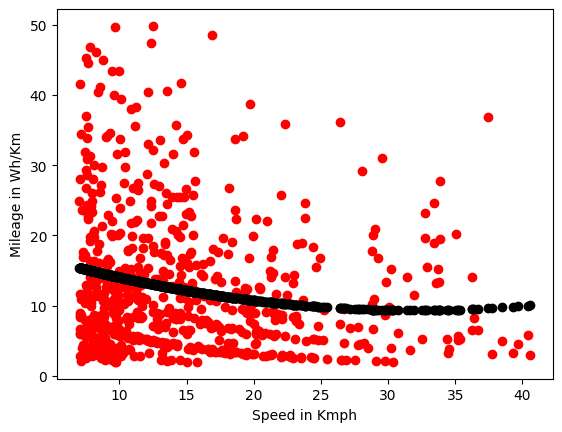

In [82]:
function=np.poly1d(function[0])
y=np.array([])
for i in ThreeMonth.Speeds:
    y=np.append(y,function(i))
plt.scatter(ThreeMonth.Speeds,ThreeMonth.MileageArray,color='red')
plt.scatter(ThreeMonth.Speeds,y,color='black')
plt.xlabel("Speed in Kmph")
plt.ylabel("Mileage in Wh/Km")

<h3><b>Here we will build a LSTM model to predict the mileage values</b></h3>
<h5>We are using the three months data as the training data and the one month data for testing</h5>

In [83]:
def cal(x):
    try:
        return int(x)
    except:
        return -1 #-1 for those values which can't be converted to int values like inf.

In [84]:
'''Here we have tried to perform decrease the number of datapoints by converting the speeds to their nearest integers.'''
ThreeMonth.df2['IntSpeed']=ThreeMonth.df2['Speed'].map(cal)
avgMileagePerSpeed=pd.DataFrame({})
avgMileagePerSpeed['Speeds']=(ThreeMonth.df2.loc[ThreeMonth.df2['IntSpeed']!=-1,'IntSpeed'].unique())
avgMileagePerSpeed['AvgMileage']=0
for i in avgMileagePerSpeed['Speeds']:
    avgMileagePerSpeed.loc[avgMileagePerSpeed['Speeds']==i,'AvgMileage']=ThreeMonth.df2.loc[ThreeMonth.df2['IntSpeed']==i,'Mileage'].mean()

Text(0.5, 0.98, 'Rounding the speeds to nearest integers and then')

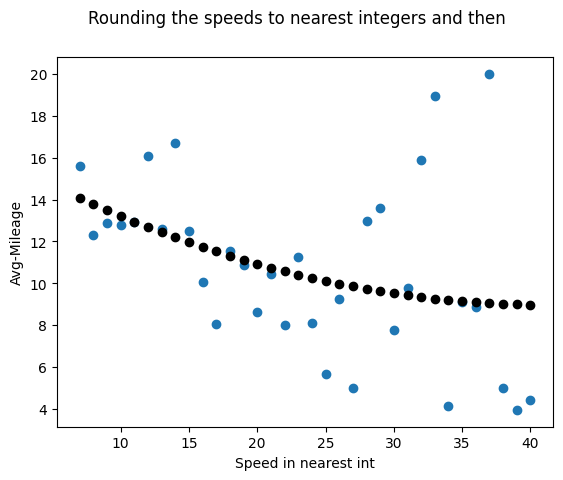

In [85]:
avgMileagePerSpeed
plt.scatter(avgMileagePerSpeed['Speeds'],avgMileagePerSpeed['AvgMileage'])
(avgMileagePerSpeed['Speeds'].to_numpy(copy=False,dtype=np.int64))
# print(avgMileagePerSpeed['Speeds'].shape,avgMileagePerSpeed['AvgMileage'].shape)
F=findBestFitFunction((avgMileagePerSpeed['Speeds'].to_numpy(copy=False,dtype=np.float64).flatten()),(avgMileagePerSpeed['AvgMileage'].to_numpy(copy=False,dtype=np.float64).flatten()),3)
plt.scatter(avgMileagePerSpeed['Speeds'],F[1],color='black')
plt.xlabel('Speed in nearest int')
plt.ylabel('Avg-Mileage')
plt.suptitle('Rounding the speeds to nearest integers and then')

In [86]:
ThreeMonth.df2

,date,time,Mileage,Speed,batCurrent,IntSpeed
0,01/12/22,9:53:50,7.172335,7.958363,9.4,7
1,02/12/22,15:29:05,4.214392,8.271385,9.8,8
2,06/12/22,19:44:00,2.949481,8.072375,10.0,8
3,07/12/22,9:34:37,6.713477,7.042470,0.6,7
4,07/12/22,19:09:33,3.064986,7.902535,19.3,7
...,...,...,...,...,...,...
707,28/02/23,19:38:59,3.301035,10.134675,6.3,10
708,28/02/23,19:39:14,4.209404,15.863739,10.3,15
709,28/02/23,19:39:29,11.824831,11.271779,0.8,11
710,28/02/23,19:48:14,12.565971,10.611860,9.5,10


20/20 [==============================] - 0s 660us/step


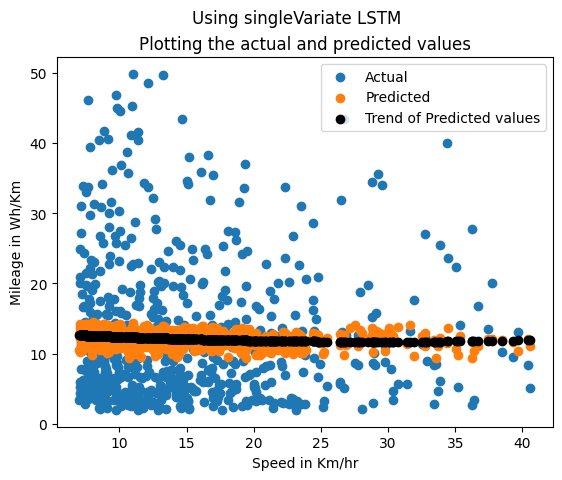

In [87]:
#The constructor's parameters are: (self,dataframe,fileName,train,percentage_test=0.8,size=3,plot=False)
trained_model_singleVariate=LSTM(ThreeMonth.df2,fileName='LSTM_Model_singleVariate.h5',size=5,percentage_train=0.9,plot=True,train=False,variate='Single')

In [88]:
OneMonth.df2

,date,time,Mileage,Speed,batCurrent
0,01/02/23,9:10:13,10.456455,7.472858,31.5
1,01/02/23,9:10:28,14.498254,16.089320,35.3
2,01/02/23,9:13:28,6.954079,16.968521,1.6
3,01/02/23,9:16:28,35.480894,7.671739,11.2
4,01/02/23,9:16:43,6.557047,8.947466,11.7
...,...,...,...,...,...
555,28/02/23,19:38:59,3.301035,10.134675,6.3
556,28/02/23,19:39:14,4.209404,15.863739,10.3
557,28/02/23,19:39:29,11.824831,11.271779,0.8
558,28/02/23,19:48:14,12.565971,10.611860,9.5


18/18 [==============================] - 0s 900us/step


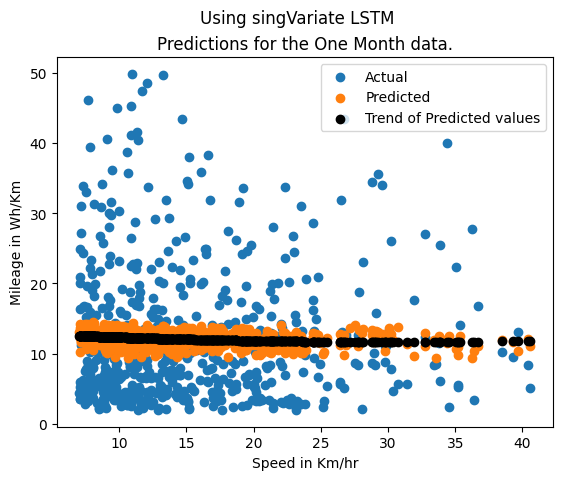

In [89]:
#Constructor for SplitData function: (percentage_test,windowed_df,size,current,training=False)
windowed=pd.DataFrame({})
windowed=LSTM.toWindowedDf(OneMonth.df2,size=trained_model_singleVariate.sizeOfWindow,variate='Single')
x_test,y_test=LSTM.splitData(percentage_train=-1,size=trained_model_singleVariate.sizeOfWindow,windowed_df=windowed,training=False,variate='Single')
#print(x_test.shape,y_test.shape)
predicted=trained_model_singleVariate.model.predict(x_test).flatten()
plt.scatter(x_test[:,0],y_test)
plt.scatter(x_test[:,0],predicted)
function=findBestFitFunction(x_test[:,0].flatten(),predicted,3)
plt.scatter(x_test[:,0],function[1],color='black')
plt.title('Predictions for the One Month data.')
plt.suptitle('Using singVariate LSTM')
plt.xlabel('Speed in Km/hr')
plt.ylabel('Mileage in Wh/Km')
plt.legend(['Actual','Predicted','Trend of Predicted values'])

20/20 [==============================] - 0s 932us/step


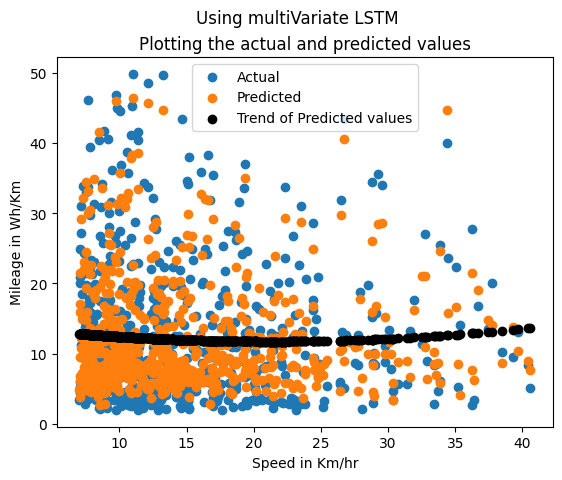

In [90]:
#This is our multivariate LSTM model using current as well as speed values and of window size =10.
trained_model_multiVariate=LSTM(ThreeMonth.df2,fileName='LSTM_Model_multiVariate.h5',size=10,percentage_train=0.9,plot=True,train=False,variate='Multi')

(550, 10, 2) (550,)
18/18 [==============================] - 0s 962us/step


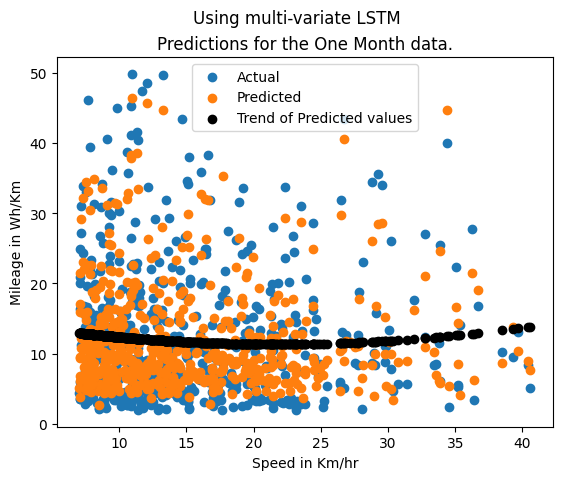

In [91]:
windowed=pd.DataFrame({})
windowed=LSTM.toWindowedDf(df=OneMonth.df2,size=trained_model_multiVariate.sizeOfWindow,variate='Multi')
x_test,y_test=LSTM.splitData(percentage_train=-1,size=trained_model_multiVariate.sizeOfWindow,windowed_df=windowed,training=False,variate='Multi')
print(x_test.shape,y_test.shape)
#windowed
predicted=trained_model_multiVariate.model.predict(x_test).flatten()
plt.scatter(x_test[:,0,0].flatten(),y_test)
plt.scatter(x_test[:,0,0].flatten(),predicted)
function=findBestFitFunction(x_test[:,0,0].flatten(),predicted,3)
plt.scatter(x_test[:,0,0].flatten(),function[1],color='black')
plt.title('Predictions for the One Month data.')
plt.suptitle('Using multi-variate LSTM')
plt.xlabel('Speed in Km/hr')
plt.ylabel('Mileage in Wh/Km')
plt.legend(['Actual','Predicted','Trend of Predicted values'])